In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt 
plt.show()

In [14]:
def f(x):
    return x ** 3 - 3 * x ** 2 + 1

In [15]:
f(3.0)

1.0

In [16]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [17]:
ys = f(xs)

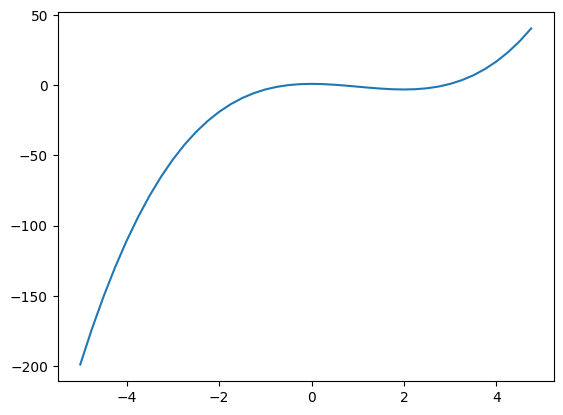

In [18]:
plt.plot(xs, ys)

In [19]:
h = -0.0000000001
x = 4
display((f(x + h) - f(x)) / h)

24.000001985768904

In [20]:
a = 3.0
b = 4.0
c = 5.0
d = a * b - c
print(d)

7.0


In [21]:
h = 0.0001 

a = 3.0
b = 4.0
c = 5.0
d1 = a * b - c
b += h
d2 = a * b - c
print(d1)
print(d2)
print('slope', (d2 - d1) / h)

7.0
7.000299999999999
slope 2.9999999999930083


In [22]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data      = float(data)
        self.grad      = 0.0
        self._backward = lambda: None
        self._prev     = set(_children)
        self._op       = _op
        self.label     = label

    def __repr__(self):
        return f"Value(data={self.data:.4g}, grad={self.grad:.4g}, op='{self._op}', label='{self.label}')"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    __radd__ = __add__           

    def __neg__(self):
        out = Value(-self.data, (self,), 'neg')
        def _backward():
            self.grad += -1.0 * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return Value(other) + (-self)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    __rmul__ = __mul__

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        if other.data == 0:
            raise ZeroDivisionError("Không thể chia cho 0")
        out = Value(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad  += (1.0 / other.data) * out.grad
            other.grad += (-self.data / (other.data**2)) * out.grad
        out._backward = _backward
        return out
    def __rtruediv__(self, other):
        return Value(other) / self

    def __pow__(self, power):
        if isinstance(power, Value):
            out = Value(self.data ** power.data, (self, power), 'pow')
            def _backward():
                # d(out)/d(self)   = p * x^(p-1)
                # d(out)/d(power) = ln(x) * x^p
                self.grad   += power.data * (self.data ** (power.data - 1)) * out.grad
                power.grad  += math.log(self.data + 1e-20) * out.data * out.grad
            out._backward = _backward
        else:
            out = Value(self.data ** power, (self,), f'**{power}')
            def _backward():
                self.grad += power * (self.data ** (power - 1)) * out.grad
            out._backward = _backward
        return out

    def tanh(self):
        t = np.tanh(self.data)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(self.data if self.data > 0 else 0.0, (self,), 'relu')
        def _backward():
            self.grad += (1.0 if self.data > 0 else 0.0) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        e = math.exp(self.data)
        out = Value(e, (self,), 'exp')
        def _backward():
            self.grad += e * out.grad     
        out._backward = _backward
        return out

    def log(self):
        out = Value(math.log(self.data + 1e-20), (self,), 'log')
        def _backward():
            self.grad += (1.0 / self.data) * out.grad
        out._backward = _backward
        return out

    def sin(self):
        s = math.sin(self.data)
        out = Value(s, (self,), 'sin')
        def _backward():
            self.grad += math.cos(self.data) * out.grad
        out._backward = _backward
        return out

    def cos(self):
        c = math.cos(self.data)
        out = Value(c, (self,), 'cos')
        def _backward():
            self.grad += -math.sin(self.data) * out.grad
        out._backward = _backward
        return out

    def tan(self):
        t = math.tan(self.data)
        out = Value(t, (self,), 'tan')
        def _backward():
            self.grad += (1.0 + t ** 2) * out.grad   # sec^2(x)
        out._backward = _backward
        return out

    def sigmoid(self):
        s = 1 / (1 + math.exp(-self.data))
        out = Value(s, (self,), 'sigmoid')
        def _backward():
            self.grad += s * (1 - s) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo, visited = [], set()
        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build(child)
                topo.append(v)
        build(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [23]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a + b; c.label = 'c'
a / b

Value(data=-0.6667, grad=0, op='/', label='')

In [24]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a + b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'l'
L.backward()

In [25]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="%s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


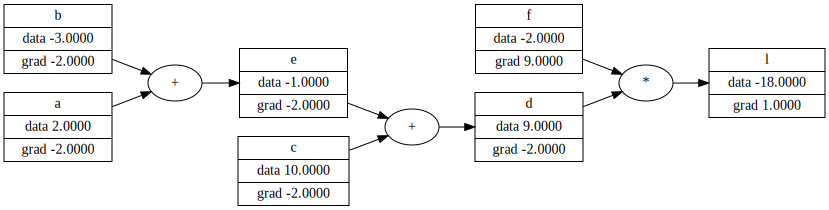

In [26]:
draw_dot(L)

In [27]:
def cal():
    h = 0.01
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a + b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L1 = d * f; L1.label = 'l'
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a + b; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label='f')
    L2 = d * f; L2.label = 'l'
    print((L2.data - L1.data) / h)
cal()


-1.9999999999999574


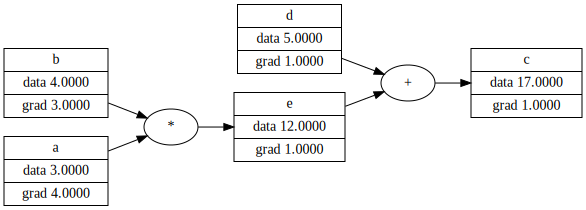

In [28]:
a = Value(3.0, label='a')
b = Value(4.0, label='b')
d = Value(5.0, label='d')
e = a * b; e.label = 'e'
c = e + d; c.label = 'c'
c.backward()
draw_dot(c)

dl/dc = dl/dd * dd/dc
dd/dc = 1
dd/de  = 1

In [29]:
L.grad = 1
d.grad = f.data
f.grad = d.data
e.grad = d.grad
c.grad = d.grad
a.grad = e.grad
b.grad = -2
print(b.grad)
# z = x * y
# dz/dy = x
# dz/dx = y

-2


In [30]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
        
build_topo(L)
topo[::-1]

[Value(data=-18, grad=1, op='*', label='l'),
 Value(data=9, grad=-2, op='+', label='d'),
 Value(data=10, grad=-2, op='', label='c'),
 Value(data=-1, grad=-2, op='+', label='e'),
 Value(data=-3, grad=-2, op='', label='b'),
 Value(data=2, grad=-2, op='', label='a'),
 Value(data=-2, grad=5, op='', label='f')]

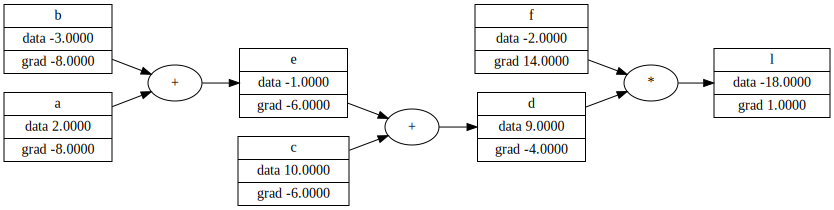

In [31]:
L.backward()
draw_dot(L)

In [32]:
# dl/dc = dl/dd * dd / dc
def traverse(root):
    if len(root._prev) == 0:
        return
    for i in root._prev:
        print(i) 
        traverse(i)
traverse(L)

Value(data=-2, grad=14, op='', label='f')
Value(data=9, grad=-4, op='+', label='d')
Value(data=-1, grad=-6, op='+', label='e')
Value(data=2, grad=-8, op='', label='a')
Value(data=-3, grad=-8, op='', label='b')
Value(data=10, grad=-6, op='', label='c')


Simple neuron with 2 input and 2 neurons

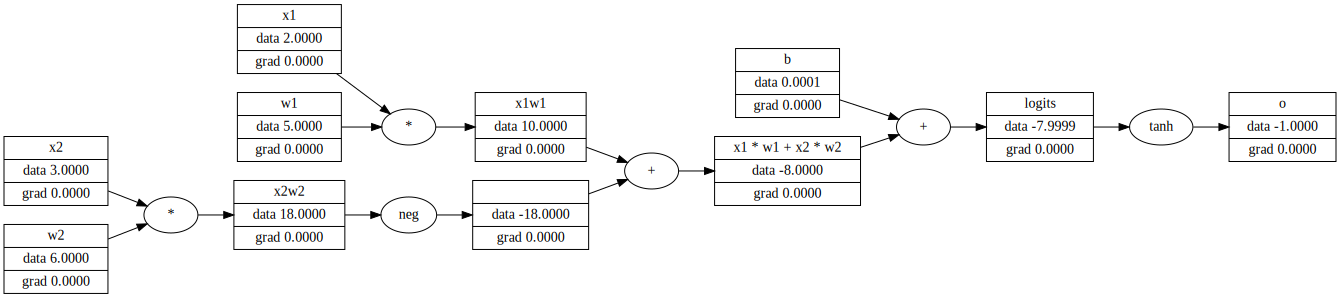

In [33]:
x1 = Value(2); x1.label = 'x1'
x2 = Value(3); x2.label = 'x2'
w1 = Value(5); w1.label = 'w1'
w2 = Value(6); w2.label = 'w2'
b = Value(0.0001); b.label = 'b'
w1_x1 = x1 * w1; w1_x1.label = 'x1w1'
w2_x2 = x2 * w2; w2_x2.label = "x2w2"
h1 = w1_x1 - w2_x2; h1.label = "x1 * w1 + x2 * w2"
logits = h1 + b; logits.label = 'logits'
output = logits.tanh()
output.label = "o"
draw_dot(output)

In [34]:
output.grad = 1
# output = tanh(logits)
# d output / d logits = 1 - tanh(logits) ** 2
logits.grad = 1 - np.tanh(logits.data) ** 2
logits.grad

4.502306347742291e-07

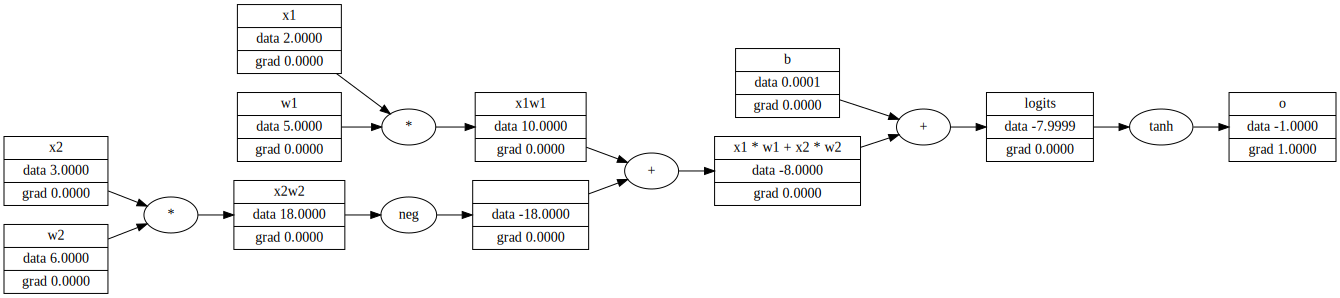

In [35]:
draw_dot(output)